In [1]:
%matplotlib notebook

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import imageio
import hyperspy.api as hs
from stemutils.io import *

dirname = '/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/'

In [3]:
class RobotDataset():
    def __init__(self, pattern_size = 128, vac = None):
        self.patt_size = pattern_size
        self.full = np.round(np.array(imageio.imread('/home/dto55534/Downloads/robot.png'))[::4,::4].mean(axis=-1),0)
        self.plane = np.zeros_like(self.full)
        if np.all(vac == None):
            eg = hs.load('/dls/e02/data/2021/mg28034-1/processing/Merlin/Calibrated/O3_pure/20210305 115108/20210305_115108.hdf5',lazy= True)
            vac = eg.data[6,16]
        self.vac = self.process(vac)
        self.map = np.zeros((self.full.shape[0],self.full.shape[1]))
        shape4d = [self.full.shape[0],self.full.shape[1],self.patt_size, self.patt_size]
        self.empty4d = np.zeros(shape4d)
        self.empty4d[:,:] = self.vac
        self.lpupil = self.get_region(112)
        self.liris = self.get_region(130)
        self.lwhite = self.get_region(159)
        self.rpupil = self.get_region(245)
        self.riris = self.get_region(74)
        self.rwhite = self.get_region(92)
        self.leye = self.combined_region([self.lpupil, self.liris, self.lwhite])
        self.reye = self.combined_region([self.rpupil, self.riris, self.rwhite])
        self.eyes = self.combined_region([self.leye, self.reye])
        self.w = self.get_region(219)
        self.nw = self.get_region(193)
        self.n = self.get_region(150)
        self.ne = self.get_region(106)
        self.e = self.get_region(81)
        self.bond = self.combined_region([self.w, self.nw, self.n, self.ne, self.e])
        self.bar = self.get_region(188)
        
    def set_region(self, region, patts, reset = True):
        if reset == True:
            out = self.empty4d
            self.map = np.zeros((self.full.shape[0],self.full.shape[1]))
        else:
            out = self.current
        current_map_max = self.map.max() +1
        for ind, patt in enumerate(patts):
            if patt.size != self.patt_size**2:
                patt = self.process(patt)
            out[np.where(region==ind+1)]=patt
            self.map[np.where(region==ind+1)] = ind + current_map_max
        self.current = out
    
    def dogleg(self, x):
        if x < 0.25:
            return x*2
        else:
            return (2/3)*x +(1/3)
    
    def set_bar(self, patt1, patt2, reset = True, factor_method = 'linear'):
        if reset == True:
            out = self.empty4d
            self.map = np.zeros((self.full.shape[0],self.full.shape[1]))
        else:
            out = self.current
        if patt1.size != self.patt_size**2:
            patt1 = self.process(patt1)
        if patt2.size != self.patt_size**2:
            patt2 = self.process(patt2)
        x,y = np.where(self.bar == 1)
        current_map_max = self.map.max() + 1
        self.map[np.where(self.bar==1)] = current_map_max
        ymax, ymin = y.max(), y.min()
        ydiff= ymax-ymin
        bar_patterns = patt2[np.newaxis,:,:]
        for yval in range(ymin+1, ymax+1):
            if factor_method == 'linear':
                factor = (yval-ymin)/ydiff
            if factor_method == 'dogleg':
                factor = self.dogleg((yval-ymin)/ydiff)
            patt = patt1*factor + patt2*(1-factor)
            bar_patterns = np.concatenate((bar_patterns, patt[np.newaxis,:,:]),axis=0)
        for ind, yval in enumerate(y):
            xval = x[ind]
            out[xval,yval] = bar_patterns[yval-ymin]
        self.current = out
        
    def output_signal(self):
        sig = hs.signals.Signal2D(self.current)
        sig.add_poissonian_noise()
        sig.change_dtype('uint8')
        return sig
        
    def get_region(self, val):
        return np.where(self.full == val,1,0)
    def combined_region(self, regs):
        blank = np.zeros_like(self.plane)
        nums = [0]
        for each in regs:
            nums.append(each.max())
        tot=0
        for ind, reg in enumerate(regs):
            blank += reg + np.where(reg != 0,1,0)*(nums[ind]+tot)
            tot += nums[ind]
        return blank
    def view_region(self,im):
        plt.figure()
        plt.imshow(im)
    def view_signal(self):
        s = hs.signals.Signal2D(self.current)
        s.plot()
        self.signal = s
    def process(self, img):
        img = img/img.max()
        s1 = resize(img, (self.patt_size,self.patt_size))
        s1 *= 64
        return s1

In [4]:
from skimage import data, io, filters

from skimage.transform import resize, rotate

base = hs.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/PaperDataRepo/SimulatedData/o3_patterns.hdf5')

<IPython.core.display.Javascript object>


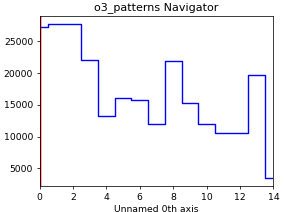

<IPython.core.display.Javascript object>


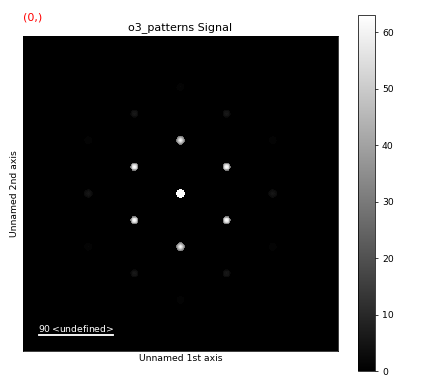

In [5]:
base.plot()

In [12]:
ds = RobotDataset(128, vac = base.data[-1])

In [13]:
bond_patterns = [base.data[i] for i in range(0,5)]

In [14]:
ds.set_region(ds.bond,bond_patterns)

<IPython.core.display.Javascript object>


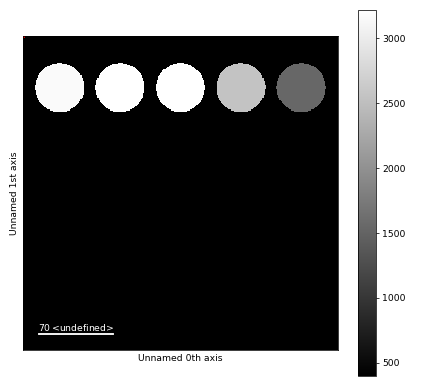

<IPython.core.display.Javascript object>


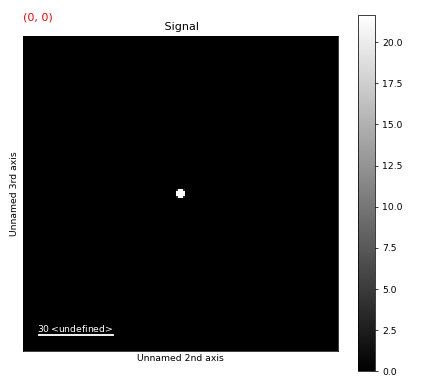

In [15]:
ds.view_signal()

In [16]:
eye_patterns = [base.data[i] for i in range(5,11)]

In [17]:
ds.set_region(ds.eyes, eye_patterns, reset= False)

<IPython.core.display.Javascript object>


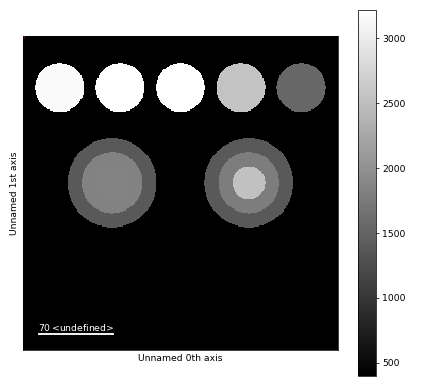

<IPython.core.display.Javascript object>


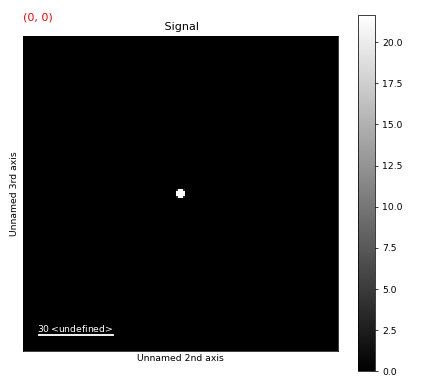

In [18]:
ds.view_signal()

In [19]:
ds.set_bar(base.data[12], ds.vac, reset= False)

<IPython.core.display.Javascript object>


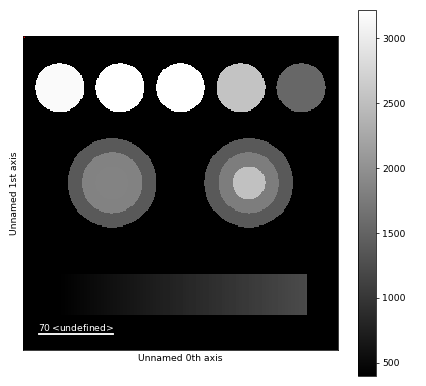

<IPython.core.display.Javascript object>


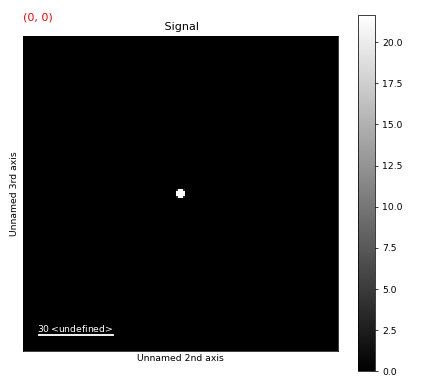

In [20]:
ds.view_signal()

<IPython.core.display.Javascript object>


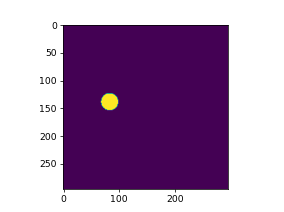

In [25]:
plt.figure()
plt.imshow(ds.lpupil)

In [26]:
ds.current

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [28]:
amorphous = hs.load('/dls/science/groups/imaging/ePSIC_students/Andy_Bridger/mg28034-1/processing/Merlin/Calibrated/P2_pure/20210304 165739/20210304_165739.hdf5')

In [82]:
am = flatten_nav(amorphous.inav[60:100,120:160].data)
am = np.asarray([resize(p, (200,200), anti_aliasing=True) for p in am])
am = am[:, am.shape[1]//2-64: am.shape[1]//2+64, am.shape[2]//2-64: am.shape[2]//2+64]
am = (am/np.max(am, axis = (1,2))[:,None,None])*63
am[:,21:23,112:114] = np.zeros((2,2))

<IPython.core.display.Javascript object>


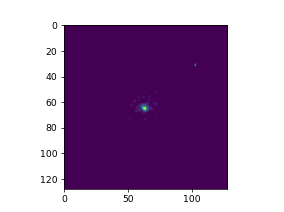

In [83]:
plt.figure()
plt.imshow(am[1])

In [84]:
am_patts = am[np.random.choice(np.arange(am.shape[0]), np.where(ds.lpupil ==1)[0].shape[0])]

In [85]:
ds.current[np.where(ds.lpupil ==1)] = am_patts

<IPython.core.display.Javascript object>


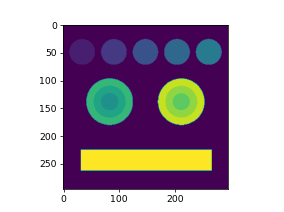

In [86]:
plt.figure()
plt.imshow(ds.map)

In [87]:
sig = ds.output_signal()

<IPython.core.display.Javascript object>


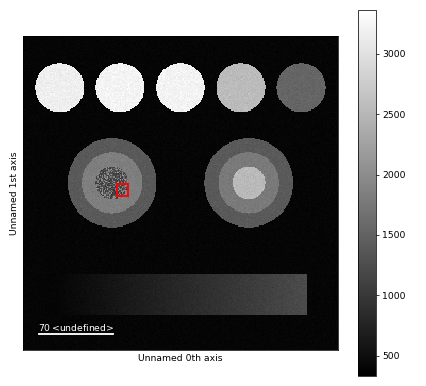

<IPython.core.display.Javascript object>


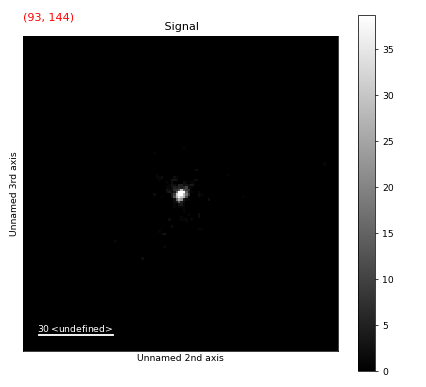

In [88]:
sig.plot()

In [89]:
sig.save(dirname+'SimulatedDSA-data.hdf5')

In [90]:
np.save(dirname + 'SimulatedDSA-gtmap.npy', ds.map)